# Joint project AMD + SM2L

https://docs.google.com/document/d/1oqoIyRUI_digfIokf53fox0I1eWiTFzQaae-PxMre0Y/edit

The task is to implement from scratch a learning algorithm for **regression** with **square loss** (e.g., **ridge regression**). The label to be predicted must be selected among the following 5 attributes, removing the remaining 4 from the dataset:
- PERNP (Person's earnings)
- PINCP (Person's income)
- WAGP (Wages or salary income past 12 months)
- HINCP (Household income)
- FINCP (Family income)

This code is run inside the Docker container provided in the course.

## Dataset

The project is based on the analysis of the «2013 American Community Survey» dataset published on Kaggle and released under the public domain license (CC0).

https://www.kaggle.com/census/2013-american-community-survey

The American Community Survey is an ongoing survey from the US Census Bureau. In this survey, approximately 3.5 million households per year are asked detailed questions about who they are and how they live. Many topics are covered, including ancestry, education, work, transportation, internet use, and residency.

There are two types of survey data provided, housing and population:
- For the housing data, each row is a housing unit, and the characteristics are properties like rented vs. owned, age of home, etc.
- For the population data, each row is a person and the characteristics are properties like age, gender, whether they work, method/length of commute, etc.

Each data set is divided in two pieces, "a" and "b":
- "a" contains states 1 to 25;
- "b" contains states 26 to 50.

Both data sets have weights associated with them. Weights are included to account for the fact that individuals are not sampled with equal probably (people who have a greater chance of being sampled have a lower weight to reflect this):
- Weight variable for the housing data: WGTP
- Weight variable for the population data: PWGTP

### Setup Kaggle API

In [5]:
# install kaggle API for providing the dataset
!pip install --user kaggle

Processing /home/jovyan/.cache/pip/wheels/aa/e7/e7/eb3c3d514c33294d77ddd5a856bdd58dc9c1fabbed59a02a2b/kaggle-1.5.6-py3-none-any.whl
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
# add kaggle to PATH environment variable
import os
os.environ["PATH"] += os.pathsep + "/home/jovyan/.local/bin"

In [14]:
!mkdir ~/.kaggle
!echo '{"username":"teresatanzi","key":"a64ec0d865925975d3318adf576216b7"}' >> ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [18]:
!export KAGGLE_USERNAME=teresatanzi
!export KAGGLE_KEY=a64ec0d865925975d3318adf576216b7

In [4]:
# uncomment to uninstall kaggle
#!python -c "print('y')" | pip uninstall kaggle

Found existing installation: kaggle 1.5.6
Uninstalling kaggle-1.5.6:
  Would remove:
    /home/jovyan/.local/bin/kaggle
    /home/jovyan/.local/lib/python3.7/site-packages/kaggle-1.5.6.dist-info/*
    /home/jovyan/.local/lib/python3.7/site-packages/kaggle/*
Proceed (y/n)?   Successfully uninstalled kaggle-1.5.6


In [66]:
!pyspark --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 2.4.5
      /_/
                        
Using Scala version 2.11.12, OpenJDK 64-Bit Server VM, 1.8.0_252
Branch HEAD
Compiled by user centos on 2020-02-02T19:38:06Z
Revision cee4ecbb16917fa85f02c635925e2687400aa56b
Url https://gitbox.apache.org/repos/asf/spark.git
Type --help for more information.


### Dataset download

The dataset should not be added to the repository, but downloaded during code execution, for instance via the kaggle API 

https://github.com/Kaggle/kaggle-api

In [8]:
!mkdir ./data
!kaggle datasets download census/2013-american-community-survey -p ./data

100%|███████████████████████████████████████▉| 916M/916M [02:56<00:00, 5.74MB/s]
100%|████████████████████████████████████████| 916M/916M [02:56<00:00, 5.45MB/s]


In [9]:
import zipfile

with zipfile.ZipFile("./data/2013-american-community-survey.zip","r") as zip_ref:
    zip_ref.extractall("./data/2013-american-community-survey")

### Reading the data

The task is to implement from scratch a learning algorithm for regression with square loss (e.g., ridge regression). The label to be predicted must be selected among the following 5 attributes, removing the remaining 4 from the dataset:

- pusa dataset:
    - PERNP (Person's earnings)
    - PINCP (Person's income)
    - WAGP (Wages or salary income past 12 months)
- husa dataset:
    - HINCP (Household income)
    - FINCP (Family income)

In [1]:
import pyspark
sc = pyspark.SparkContext('local[*]')

In [2]:
import os.path

baseDir = os.path.join('./data/2013-american-community-survey')
#inputPathA = os.path.join('ss13pusa.csv')
#inputPathB = os.path.join('ss13pusb.csv')
inputPathA = os.path.join('ss13husa.csv')
inputPathB = os.path.join('ss13husb.csv')
fileNameA = os.path.join(baseDir, inputPathA)
fileNameB = os.path.join(baseDir, inputPathB)

numPartitions = 2
rawDataA = sc.textFile(fileNameA, numPartitions)
rawDataB = sc.textFile(fileNameB, numPartitions)

In [3]:
header = sc.parallelize([rawDataA.first()])                                    #extract header
rawData = rawDataA.subtract(header).union(rawDataB.subtract(header))           #filter out header

In [4]:
n = rawData.count()

In [5]:
rawData.take(1)

['H,709,6,02300,3,01,1000000,1007549,00025,01,1,3,2,1,1,03,02,,2,2,,,,100,,1,0002,030,2,2,,2,,,,,,,,1,05,,,1,9,,1,,1,1,4,1,,,0,0010,4,,0,,0,,,,,,1,6,000007700,0,4,4,4,1,1,1,7,00,,0,0,00,,0,1,0,0,1,1,1,,,1,0,0,,,,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,00007,00022,00028,00017,00044,00026,00021,00006,00028,00006,00015,00024,00028,00041,00050,00006,00026,00030,00018,00049,00006,00043,00023,00031,00032,00023,00020,00006,00039,00006,00008,00028,00038,00030,00042,00011,00032,00037,00019,00006,00038,00022,00044,00016,00006,00033,00033,00035,00005,00026,00065,00027,00025,00010,00011,00047,00028,00021,00017,00007,00029,00031,00029,00026,00006,00022,00023,00022,00007,00039,00031,00022,00025,00007,00005,00037,00081,00054,00024,00032']

In [6]:
headerList = header.take(1)[0].split(',')
print(len(headerList))

231


## Preprocessing

We should trasform data in objects belonging to the class LabeledPoint, but first we have to solve some issues:

- we have to deal with missing values: we can substitute those with mean or median of the corresponding column; <br>
https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4
- we have to deal with categorical values: it should be fine to just discard the feature, because only the first feature is categorical and it has a constant value for all the entry;
- we have to deal with missing values in the labels: we could discard data points with no label, because they don't really help in the training process.

#### Dataframe

Let's start reading the data as a pyspark dataframe

In [7]:
from pyspark.sql import SQLContext

sqlContext = SQLContext(sc)

In [8]:
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import StringType

schema = StructType([StructField(i, StringType(), True) for i in headerList])
df = sqlContext.createDataFrame(rawData.map(lambda row: row.split(',')), schema)

In [9]:
df.printSchema()

root
 |-- RT: string (nullable = true)
 |-- SERIALNO: string (nullable = true)
 |-- DIVISION: string (nullable = true)
 |-- PUMA: string (nullable = true)
 |-- REGION: string (nullable = true)
 |-- ST: string (nullable = true)
 |-- ADJHSG: string (nullable = true)
 |-- ADJINC: string (nullable = true)
 |-- WGTP: string (nullable = true)
 |-- NP: string (nullable = true)
 |-- TYPE: string (nullable = true)
 |-- ACCESS: string (nullable = true)
 |-- ACR: string (nullable = true)
 |-- AGS: string (nullable = true)
 |-- BATH: string (nullable = true)
 |-- BDSP: string (nullable = true)
 |-- BLD: string (nullable = true)
 |-- BROADBND: string (nullable = true)
 |-- BUS: string (nullable = true)
 |-- COMPOTHX: string (nullable = true)
 |-- CONP: string (nullable = true)
 |-- DIALUP: string (nullable = true)
 |-- DSL: string (nullable = true)
 |-- ELEP: string (nullable = true)
 |-- FIBEROP: string (nullable = true)
 |-- FS: string (nullable = true)
 |-- FULP: string (nullable = true)
 |-- GA

In [10]:
df.show(n = 1)

+---+--------+--------+-----+------+---+-------+-------+-----+---+----+------+---+---+----+----+---+--------+---+--------+----+------+---+----+-------+---+----+----+--------+---+----+------+---+-----+----+----+----+----+--------+----+----+----+----+----+------+---------+----+---+----+---+---+----+----+----+---+----+---+---+------+------+------+-----+-----+------+-----+-----+---+---+---------+-----+-----+------+------+---+----+-----+---+---+---+---+---+---+-----+-------+---+---+---+---+---+-------+-----+---+----+----+----+----+---+-------+--------+--------+-----+-----+------+-----+-----+----------+-----+----------+-----+--------+-----+-----+---------+----+-----+-----+----------+-----+-----+-----+--------+----+-------+------+-----+------+------+----+----------+-----+------+-----+------+-----+------+--------+-----------+------+----+------+------+------+-----+-----+-----+------+------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+------+------+

In [11]:
from pyspark.sql.types import DoubleType

for i in headerList:
    # RT in a string and it has a constant value for all the points
    if i != 'RT': df = df.withColumn(i, df[i].cast(DoubleType()))

In [12]:
# removing the first column because:
# it's a string (it can couse problems when we want to perform some operations on all the dataframe)
# it has a constant value (so, it's not informative)

# ! COLLECT E' UN'OPERAZIONE MOLTO LENTA
# when the data size is large, collect() might cause heap space error. you can also create a new dataframe dropping
# the extra field by ndf = df.drop('age')
df = df.drop('RT')

### Deal with null values

https://stackoverflow.com/questions/40057563/replace-missing-values-with-mean-spark-dataframe

In [13]:
df.show(n = 1)

+--------+--------+------+------+---+---------+---------+----+---+----+------+---+---+----+----+---+--------+---+--------+----+------+----+-----+-------+---+----+----+--------+---+----+------+----+-----+----+----+----+----+--------+----+----+----+----+----+------+---------+----+----+----+---+---+----+----+----+---+----+---+----+------+------+------+-----+-----+------+-----+-----+---+---+------+-----+-----+------+------+---+----+-----+---+---+----+---+---+---+-----+-------+---+---+---+---+---+-------+-----+----+----+----+----+----+----+-------+--------+--------+-----+-----+------+-----+-----+----------+-----+----------+-----+--------+-----+-----+---------+----+-----+-----+----------+-----+-----+-----+--------+----+-------+------+-----+------+------+----+----------+-----+------+-----+------+-----+------+--------+-----------+------+----+------+------+------+-----+-----+-----+------+------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+------+--

In [62]:
#from pyspark.sql.functions import col, avg

#df.filter(df['BLD'] != None).agg(avg(col("BLD")))

DataFrame[avg(BLD): double]

Let's see, for all the attributes, the percentange of null values

In [14]:
# lento
from pyspark.sql.functions import isnan, when, count, col

null_df = df.select([(count(when(col(c).isNull(), c))/n).alias(c) for c in df.columns])

In [15]:
null_df.show()

+--------+--------+----+------+---+------+------+----+---+----+------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+------------------+-------------------+-----------------+-----------------+------------------+------------------+-------------------+-------------------+-------------------+----

We may chose to remove an attribute from the feature vector if the percentage of missing values is too high.

https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4: Sometimes you can drop variables if the data is missing for more than 60% observations but only if that variable is insignificant. 

In [16]:
null_distr = null_df.collect()[0].asDict().values()

In [70]:
list(null_distr)

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.1795344212236836,
 0.2895219374211295,
 0.8369465011823374,
 0.10042314874962152,
 0.10042314874962152,
 0.10042314874962152,
 0.38344714162918025,
 0.2895219374211295,
 0.1795344212236836,
 0.9693127405909181,
 0.38344714162918025,
 0.38344714162918025,
 0.1795344212236836,
 0.38344714162918025,
 0.07911127247406208,
 0.1795344212236836,
 0.1795344212236836,
 0.1795344212236836,
 0.1795344212236836,
 0.42602618821347504,
 0.1795344212236836,
 0.9622092334078207,
 0.38344714162918025,
 0.6496068245690446,
 0.6496068245690446,
 0.6496068245690446,
 0.42602618821347504,
 0.38344714162918025,
 0.10042314874962152,
 0.10042314874962152,
 0.7563179352887904,
 0.7563179352887904,
 0.10042314874962152,
 0.10042314874962152,
 0.38344714162918025,
 0.10042314874962152,
 0.9374238389826548,
 0.10042314874962152,
 0.1795344212236836,
 0.1795344212236836,
 0.10042314874962152,
 0.920888727525938,
 0.417677010227506,
 0.1795344212236836

(array([92.,  0.,  0.,  0.,  1., 68.,  0.,  0.,  0., 32.,  0.,  0.,  0.,
         0.,  2.,  0.,  0.,  0.,  0.,  7.,  0.,  6.,  1.,  7.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,
         5.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  2.]),
 array([0.        , 0.01938625, 0.03877251, 0.05815876, 0.07754502,
        0.09693127, 0.11631753, 0.13570378, 0.15509004, 0.17447629,
        0.19386255, 0.2132488 , 0.23263506, 0.25202131, 0.27140757,
        0.29079382, 0.31018008, 0.32956633, 0.34895259, 0.36833884,
        0.3877251 , 0.40711135, 0.42649761, 0.44588386, 0.46527012,
        0.48465637, 0.50404263, 0.52342888, 0.54281513, 0.56220139,
        0.58158764, 0.6009739 , 0.62036015, 0.63974641, 0.65913266,
        0.67851892, 0.69790517, 0.71729143, 0.73667768, 0.75606394,
        0.77545019, 0.79483645, 0.8142227 , 0.83360896, 0.85299521,
        0.87238147, 0.89176772, 0.91115398, 0.93054023, 0.94992649,
        0.96931274]),
 <a list of 50

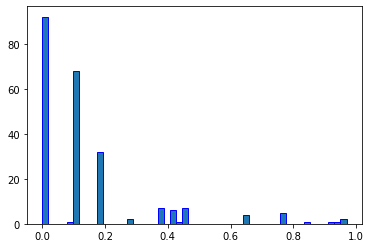

In [17]:
#import numpy as np
import matplotlib.pyplot as plt

#np.around(list(null_distr), decimals = 1)
plt.hist(list(null_distr), edgecolor = 'blue', bins = 50)

Let's now check the number of null values in each row (we may want to delete also some rows if the fraction of null values is too high).

However in most cases, it is often disadvantageous to use listwise deletion. This is because the assumptions of MCAR (Missing Completely at Random) are typically rare to support. As a result, listwise deletion methods produce biased parameters and estimates.

In [47]:
null_row_df = df.withColumn('numNulls', sum(df[col].isNull().cast('int')/(len(headerList) - 1) for col in df.columns))
null_row_df.show(1)

+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+----+------+----+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+----+--------------------+----+-----+----+----+----+----+--------+--------------------+--------------------+----+----+--------------------+--------------------+---------+--------------------+----+--------------------+--------------------+--------------------+--------------------+----+----+---+--------------------+--------------------+----+------+------+------+-----+-----+------+-----+-----+--------------------+--------------------+--------------------+-----+---

In [50]:
# lentissimo

null_row_df.filter(null_row_df.numNulls > .6).count()

0

In [51]:
null_row_df.filter(null_row_df.numNulls > .2).count()

265049

Let us not delete any row. We may want to check if the number of row with a significative percentage of null values decrease after we remove the most null features (we actually expect so).

#### Remove colums with more of 60% of missing values

In [18]:
#[value for value in list(null_distr) if value > .6]

import numpy as np

for i in np.where(np.array(list(null_distr)) > .6)[0]:
    #print(i)
    #print(headerList[i + 1])
    df = df.drop(headerList[i + 1])
    
df.show(1)

+--------+--------+------+------+---+---------+---------+----+---+----+------+---+----+----+---+--------+---+--------+------+----+-----+-------+---+----+----+--------+---+----+------+-----+----+--------+----+----+----+------+---------+----+----+---+---+----+----+---+----+---+----+------+------+-----+-----+------+---+---+------+-----+-----+------+------+---+----+-----+---+---+----+---+---+---+-----+-------+---+---+---+---+---+-------+-----+----+----+----+----+----+-------+--------+--------+-----+-----+------+-----+-----+----------+-----+----------+-----+--------+-----+-----+---------+----+-----+-----+----------+-----+-----+-----+--------+----+-------+------+-----+------+------+----+----------+-----+------+-----+------+-----+------+--------+-----------+------+----+------+------+------+-----+-----+-----+------+------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+------+------+------+------+------+------+------+------+------+------+------+-----

In [21]:
print('We reduced the number of attributes from {} to {}.'.format(len(headerList), len(df.columns)))

We reduced the number of attributes from 231 to 216.


# TODO

#### Replace the missing values with the mean (or median) value of the column

In [ ]:
# lento
from pyspark.ml.feature import Imputer

#imputer = Imputer(
#    inputCols = df.columns, 
#    outputCols = ["{}_imputed".format(c) for c in df.columns],
#    strategy = 'mean'
#)

imputer = Imputer()
imputer.setInputCols(df.columns)
imputer.setOutputCols(["{}_imputed".format(c) for c in df.columns])
imputer.setStrategy("median")

imputer.fit(df).transform(df)

Py4JJavaError: An error occurred while calling o2517.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 4 in stage 29.0 failed 1 times, most recent failure: Lost task 4.0 in stage 29.0 (TID 231, localhost, executor driver): java.lang.OutOfMemoryError: GC overhead limit exceeded
	at java.lang.Double.valueOf(Double.java:519)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificSafeProjection.createExternalRow_0_7$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificSafeProjection.CreateExternalRow_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificSafeProjection.apply(Unknown Source)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1334)
	at scala.collection.TraversableOnce$class.foldLeft(TraversableOnce.scala:157)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1334)
	at scala.collection.TraversableOnce$class.aggregate(TraversableOnce.scala:214)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1334)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1$$anonfun$26.apply(RDD.scala:1190)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1$$anonfun$26.apply(RDD.scala:1190)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1$$anonfun$27.apply(RDD.scala:1191)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1$$anonfun$27.apply(RDD.scala:1191)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:823)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:823)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1891)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1879)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1878)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1878)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2112)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2061)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2050)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:738)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2158)
	at org.apache.spark.rdd.RDD$$anonfun$fold$1.apply(RDD.scala:1143)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:385)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1137)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1.apply(RDD.scala:1206)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:385)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1182)
	at org.apache.spark.sql.execution.stat.StatFunctions$.multipleApproxQuantiles(StatFunctions.scala:102)
	at org.apache.spark.sql.DataFrameStatFunctions.approxQuantile(DataFrameStatFunctions.scala:100)
	at org.apache.spark.ml.feature.Imputer.fit(Imputer.scala:151)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.OutOfMemoryError: GC overhead limit exceeded
	at java.lang.Double.valueOf(Double.java:519)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificSafeProjection.createExternalRow_0_7$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificSafeProjection.CreateExternalRow_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificSafeProjection.apply(Unknown Source)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1334)
	at scala.collection.TraversableOnce$class.foldLeft(TraversableOnce.scala:157)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1334)
	at scala.collection.TraversableOnce$class.aggregate(TraversableOnce.scala:214)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1334)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1$$anonfun$26.apply(RDD.scala:1190)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1$$anonfun$26.apply(RDD.scala:1190)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1$$anonfun$27.apply(RDD.scala:1191)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1$$anonfun$27.apply(RDD.scala:1191)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:823)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:823)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 45014)
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1159, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 985, in send_command
    response = connection.send_command(command)
  File "/usr/local/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1164, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
py4j.protocol.Py4JNetworkError: Error while receiving
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/socketserver.py", line 316, in _ha